In [1]:
"""
function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("#ok").click()
}
setInterval(ClickConnect,60000)
"""

'\nfunction ClickConnect(){\n    console.log("Clicked on connect button"); \n    document.querySelector("#ok").click()\n}\nsetInterval(ClickConnect,60000)\n'

In [2]:
!nvidia-smi

Mon Jul 13 06:25:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import pandas as pd
import os

In [4]:
!pip install -U PyYAML

     |████████████████████████████████| 276kB 4.8MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=f6bf59381911d2a9095c4d2ce7a64d944148f4c32133c7591ced9b76fbc70a90
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built PyYAML
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
%%writefile setup.sh

export CUDA_HOME=/usr/local/cuda-10.1
git clone https://github.com/NVIDIA/apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

Writing setup.sh


In [6]:
!sh setup.sh

Cloning into 'apex'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 7335 (delta 40), reused 42 (delta 19), pack-reused 7255
Receiving objects: 100% (7335/7335), 13.88 MiB | 26.27 MiB/s, done.
Resolving deltas: 100% (4941/4941), done.
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-t5tafojk
Created temporary directory: /tmp/pip-req-tracker-erlxzrnm
Created requirements tracker '/tmp/pip-req-tracker-erlxzrnm'
Created temporary directory: /tmp/pip-install-1y_rv6x4
Processing ./apex
  Created temporary directory: /tmp/pip-req-build-enrziaqt
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-erlxzrnm'
    Running setup.py (path

In [7]:
import torch.random
import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [8]:
zip_name = 'split-fold3.zip'
zip_path = '/content/drive/My Drive/Colab Notebooks/gwdsplit/' + zip_name
!cp "{zip_path}" .
!unzip -q '{zip_name}'
!rm '{zip_name}'

In [9]:
yolov5_name = 'yolov5.zip'
yolov5_path = '/content/drive/My Drive/Colab Notebooks/' + yolov5_name
!cp '{yolov5_path}' .
!unzip -q '{yolov5_name}'
!rm '{yolov5_name}'

In [10]:
weight_name = 'yolov5x_coco.pt'
weight_path = '/content/drive/My Drive/Colab Notebooks/yolov5weights/' + weight_name
!cp '{weight_path}' .

In [11]:
train_input = '/content/drive/My Drive/Colab Notebooks/yolov5/train.py'
data_input = '/content/drive/My Drive/Colab Notebooks/yolov5config/wheat_colab.yaml'
cfg_input = '/content/drive/My Drive/Colab Notebooks/yolov5config/yolov5x.yaml'
weights_input = '/content/' + weight_name
name_input = 'x-b2-e50-fold3'

In [12]:
%cd /content/yolov5/

/content/yolov5


# **train.py**

In [13]:
import argparse

import torch.distributed as dist
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data
from torch.utils.tensorboard import SummaryWriter

import test  # import test.py to get mAP after each epoch
from models.yolo import Model
from utils import google_utils
from utils.datasets import *
from utils.utils import *

mixed_precision = True
try:  # Mixed precision training https://github.com/NVIDIA/apex
    from apex import amp
except:
    print('Apex recommended for faster mixed precision training: https://github.com/NVIDIA/apex')
    mixed_precision = False  # not installed

wdir = 'weights' + os.sep  # weights dir
os.makedirs(wdir, exist_ok=True)
last = wdir + 'last.pt'
best = wdir + 'best.pt'
results_file = 'results.txt'

# Hyperparameters
hyp = {'lr0': 0.01,  # initial learning rate (SGD=1E-2, Adam=1E-3)
       'momentum': 0.937,  # SGD momentum
       'weight_decay': 5e-4,  # optimizer weight decay
       'giou': 0.05,  # giou loss gain
       'cls': 0.58,  # cls loss gain
       'cls_pw': 1.0,  # cls BCELoss positive_weight
       'obj': 1.0,  # obj loss gain (*=img_size/320 if img_size != 320)
       'obj_pw': 1.0,  # obj BCELoss positive_weight
       'iou_t': 0.20,  # iou training threshold
       'anchor_t': 4.0,  # anchor-multiple threshold
       'fl_gamma': 0.0,  # focal loss gamma (efficientDet default is gamma=1.5)
       'hsv_h': 0.014,  # image HSV-Hue augmentation (fraction)
       'hsv_s': 0.68,  # image HSV-Saturation augmentation (fraction)
       'hsv_v': 0.36,  # image HSV-Value augmentation (fraction)
       'degrees': 0.0,  # image rotation (+/- deg)
       'translate': 0.0,  # image translation (+/- fraction)
       'scale': 0.5,  # image scale (+/- gain)
       'shear': 0.0}  # image shear (+/- deg)
print(hyp)

# Overwrite hyp with hyp*.txt (optional)
f = glob.glob('hyp*.txt')
if f:
    print('Using %s' % f[0])
    for k, v in zip(hyp.keys(), np.loadtxt(f[0])):
        hyp[k] = v

# Print focal loss if gamma > 0
if hyp['fl_gamma']:
    print('Using FocalLoss(gamma=%g)' % hyp['fl_gamma'])


def train(hyp):
    epochs = opt.epochs  # 300
    batch_size = opt.batch_size  # 64
    weights = opt.weights  # initial training weights

    # Configure
    init_seeds(1)
    with open(opt.data) as f:
        data_dict = yaml.load(f, Loader=yaml.FullLoader)  # model dict
    train_path = data_dict['train']
    test_path = data_dict['val']
    nc = 1 if opt.single_cls else int(data_dict['nc'])  # number of classes

    # Remove previous results
    for f in glob.glob('*_batch*.jpg') + glob.glob(results_file):
        os.remove(f)

    # Create model
    model = Model(opt.cfg, nc=data_dict['nc']).to(device)

    # Image sizes
    gs = int(max(model.stride))  # grid size (max stride)
    imgsz, imgsz_test = [check_img_size(x, gs) for x in opt.img_size]  # verify imgsz are gs-multiples

    # Optimizer
    nbs = 64  # nominal batch size
    accumulate = max(round(nbs / batch_size), 1)  # accumulate loss before optimizing
    hyp['weight_decay'] *= batch_size * accumulate / nbs  # scale weight_decay
    pg0, pg1, pg2 = [], [], []  # optimizer parameter groups
    for k, v in model.named_parameters():
        if v.requires_grad:
            if '.bias' in k:
                pg2.append(v)  # biases
            elif '.weight' in k and '.bn' not in k:
                pg1.append(v)  # apply weight decay
            else:
                pg0.append(v)  # all else

    optimizer = optim.Adam(pg0, lr=hyp['lr0']) if opt.adam else \
        optim.SGD(pg0, lr=hyp['lr0'], momentum=hyp['momentum'], nesterov=True)
    optimizer.add_param_group({'params': pg1, 'weight_decay': hyp['weight_decay']})  # add pg1 with weight_decay
    optimizer.add_param_group({'params': pg2})  # add pg2 (biases)
    # Scheduler https://arxiv.org/pdf/1812.01187.pdf
    lf = lambda x: (((1 + math.cos(x * math.pi / epochs)) / 2) ** 1.0) * 0.9 + 0.1  # cosine
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
    print('Optimizer groups: %g .bias, %g conv.weight, %g other' % (len(pg2), len(pg1), len(pg0)))
    del pg0, pg1, pg2

    # Load Model
    google_utils.attempt_download(weights)
    start_epoch, best_fitness = 0, 0.0
    if weights.endswith('.pt'):  # pytorch format
        ckpt = torch.load(weights, map_location=device)  # load checkpoint

        # load model
        try:
            ckpt['model'] = {k: v for k, v in ckpt['model'].float().state_dict().items()
                             if model.state_dict()[k].shape == v.shape}  # to FP32, filter
            model.load_state_dict(ckpt['model'], strict=False)
        except KeyError as e:
            s = "%s is not compatible with %s. This may be due to model differences or %s may be out of date. " \
                "Please delete or update %s and try again, or use --weights '' to train from scratch." \
                % (opt.weights, opt.cfg, opt.weights, opt.weights)
            raise KeyError(s) from e

        # load optimizer
        if ckpt['optimizer'] is not None:
            optimizer.load_state_dict(ckpt['optimizer'])
            best_fitness = ckpt['best_fitness']

        # load results
        if ckpt.get('training_results') is not None:
            with open(results_file, 'w') as file:
                file.write(ckpt['training_results'])  # write results.txt

        # epochs
        start_epoch = ckpt['epoch'] + 1
        if epochs < start_epoch:
            print('%s has been trained for %g epochs. Fine-tuning for %g additional epochs.' %
                  (opt.weights, ckpt['epoch'], epochs))
            epochs += ckpt['epoch']  # finetune additional epochs

        del ckpt

    # Mixed precision training https://github.com/NVIDIA/apex
    if mixed_precision:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)


    scheduler.last_epoch = start_epoch - 1  # do not move
    # https://discuss.pytorch.org/t/a-problem-occured-when-resuming-an-optimizer/28822
    # plot_lr_scheduler(optimizer, scheduler, epochs)

    # Initialize distributed training
    if device.type != 'cpu' and torch.cuda.device_count() > 1 and torch.distributed.is_available():
        dist.init_process_group(backend='nccl',  # distributed backend
                                init_method='tcp://127.0.0.1:9999',  # init method
                                world_size=1,  # number of nodes
                                rank=0)  # node rank
        model = torch.nn.parallel.DistributedDataParallel(model)
        # pip install torch==1.4.0+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html

    # Trainloader
    dataloader, dataset = create_dataloader(train_path, imgsz, batch_size, gs, opt,
                                            hyp=hyp, augment=True, cache=opt.cache_images, rect=opt.rect)
    mlc = np.concatenate(dataset.labels, 0)[:, 0].max()  # max label class
    assert mlc < nc, 'Label class %g exceeds nc=%g in %s. Correct your labels or your model.' % (mlc, nc, opt.cfg)

    # Testloader
    testloader = create_dataloader(test_path, imgsz_test, batch_size, gs, opt,
                                   hyp=hyp, augment=False, cache=opt.cache_images, rect=True)[0]

    # Model parameters
    hyp['cls'] *= nc / 80.  # scale coco-tuned hyp['cls'] to current dataset
    model.nc = nc  # attach number of classes to model
    model.hyp = hyp  # attach hyperparameters to model
    model.gr = 1.0  # giou loss ratio (obj_loss = 1.0 or giou)
    model.class_weights = labels_to_class_weights(dataset.labels, nc).to(device)  # attach class weights
    model.names = data_dict['names']

    # Class frequency
    labels = np.concatenate(dataset.labels, 0)
    c = torch.tensor(labels[:, 0])  # classes
    # cf = torch.bincount(c.long(), minlength=nc) + 1.
    # model._initialize_biases(cf.to(device))
    if tb_writer:
        plot_labels(labels)
        tb_writer.add_histogram('classes', c, 0)

    # Check anchors
    if not opt.noautoanchor:
        check_anchors(dataset, model=model, thr=hyp['anchor_t'], imgsz=imgsz)

    # Exponential moving average
    ema = torch_utils.ModelEMA(model)

    # Start training
    t0 = time.time()
    nb = len(dataloader)  # number of batches
    n_burn = max(3 * nb, 1e3)  # burn-in iterations, max(3 epochs, 1k iterations)
    maps = np.zeros(nc)  # mAP per class
    results = (0, 0, 0, 0, 0, 0, 0)  # 'P', 'R', 'mAP', 'F1', 'val GIoU', 'val Objectness', 'val Classification'
    print('Image sizes %g train, %g test' % (imgsz, imgsz_test))
    print('Using %g dataloader workers' % dataloader.num_workers)
    print('Starting training for %g epochs...' % epochs)
    # torch.autograd.set_detect_anomaly(True)
    for epoch in range(start_epoch, epochs):  # epoch ------------------------------------------------------------------
        model.train()

        # Update image weights (optional)
        if dataset.image_weights:
            w = model.class_weights.cpu().numpy() * (1 - maps) ** 2  # class weights
            image_weights = labels_to_image_weights(dataset.labels, nc=nc, class_weights=w)
            dataset.indices = random.choices(range(dataset.n), weights=image_weights, k=dataset.n)  # rand weighted idx

        # Update mosaic border
        # b = int(random.uniform(0.25 * imgsz, 0.75 * imgsz + gs) // gs * gs)
        # dataset.mosaic_border = [b - imgsz, -b]  # height, width borders

        mloss = torch.zeros(4, device=device)  # mean losses
        print(('\n' + '%10s' * 8) % ('Epoch', 'gpu_mem', 'GIoU', 'obj', 'cls', 'total', 'targets', 'img_size'))
        pbar = tqdm(enumerate(dataloader), total=nb)  # progress bar
        for i, (imgs, targets, paths, _) in pbar:  # batch -------------------------------------------------------------
            ni = i + nb * epoch  # number integrated batches (since train start)
            imgs = imgs.to(device).float() / 255.0  # uint8 to float32, 0 - 255 to 0.0 - 1.0

            # Burn-in
            if ni <= n_burn:
                xi = [0, n_burn]  # x interp
                # model.gr = np.interp(ni, xi, [0.0, 1.0])  # giou loss ratio (obj_loss = 1.0 or giou)
                accumulate = max(1, np.interp(ni, xi, [1, nbs / batch_size]).round())
                for j, x in enumerate(optimizer.param_groups):
                    # bias lr falls from 0.1 to lr0, all other lrs rise from 0.0 to lr0
                    x['lr'] = np.interp(ni, xi, [0.1 if j == 2 else 0.0, x['initial_lr'] * lf(epoch)])
                    if 'momentum' in x:
                        x['momentum'] = np.interp(ni, xi, [0.9, hyp['momentum']])

            # Multi-scale
            if opt.multi_scale:
                sz = random.randrange(imgsz * 0.5, imgsz * 1.5 + gs) // gs * gs  # size
                sf = sz / max(imgs.shape[2:])  # scale factor
                if sf != 1:
                    ns = [math.ceil(x * sf / gs) * gs for x in imgs.shape[2:]]  # new shape (stretched to gs-multiple)
                    imgs = F.interpolate(imgs, size=ns, mode='bilinear', align_corners=False)

            # Forward
            pred = model(imgs)

            # Loss
            loss, loss_items = compute_loss(pred, targets.to(device), model)
            if not torch.isfinite(loss):
                print('WARNING: non-finite loss, ending training ', loss_items)
                return results

            # Backward
            if mixed_precision:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            # Optimize
            if ni % accumulate == 0:
                optimizer.step()
                optimizer.zero_grad()
                ema.update(model)

            # Print
            mloss = (mloss * i + loss_items) / (i + 1)  # update mean losses
            mem = '%.3gG' % (torch.cuda.memory_cached() / 1E9 if torch.cuda.is_available() else 0)  # (GB)
            s = ('%10s' * 2 + '%10.4g' * 6) % (
                '%g/%g' % (epoch, epochs - 1), mem, *mloss, targets.shape[0], imgs.shape[-1])
            pbar.set_description(s)

            # Plot
            if ni < 3:
                f = 'train_batch%g.jpg' % ni  # filename
                result = plot_images(images=imgs, targets=targets, paths=paths, fname=f)
                if tb_writer and result is not None:
                    tb_writer.add_image(f, result, dataformats='HWC', global_step=epoch)
                    # tb_writer.add_graph(model, imgs)  # add model to tensorboard

            # end batch ------------------------------------------------------------------------------------------------

        # Scheduler
        scheduler.step()

        # mAP
        ema.update_attr(model)
        final_epoch = epoch + 1 == epochs
        if not opt.notest or final_epoch:  # Calculate mAP
            results, maps, times = test.test(opt.data,
                                             batch_size=batch_size,
                                             imgsz=imgsz_test,
                                             save_json=final_epoch and opt.data.endswith(os.sep + 'coco.yaml'),
                                             model=ema.ema,
                                             single_cls=opt.single_cls,
                                             dataloader=testloader)

        # Write
        with open(results_file, 'a') as f:
            f.write(s + '%10.4g' * 7 % results + '\n')  # P, R, mAP, F1, test_losses=(GIoU, obj, cls)
        if len(opt.name) and opt.bucket:
            os.system('gsutil cp results.txt gs://%s/results/results%s.txt' % (opt.bucket, opt.name))

        # Tensorboard
        if tb_writer:
            tags = ['train/giou_loss', 'train/obj_loss', 'train/cls_loss',
                    'metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/F1',
                    'val/giou_loss', 'val/obj_loss', 'val/cls_loss']
            for x, tag in zip(list(mloss[:-1]) + list(results), tags):
                tb_writer.add_scalar(tag, x, epoch)

        # Update best mAP
        fi = fitness(np.array(results).reshape(1, -1))  # fitness_i = weighted combination of [P, R, mAP, F1]
        if fi > best_fitness:
            best_fitness = fi

        # Save model
        save = (not opt.nosave) or (final_epoch and not opt.evolve)
        if save:
            with open(results_file, 'r') as f:  # create checkpoint
                ckpt = {'epoch': epoch,
                        'best_fitness': best_fitness,
                        'training_results': f.read(),
                        'model': ema.ema,
                        'optimizer': None if final_epoch else optimizer.state_dict()}

            # Save last, best and delete
            torch.save(ckpt, last)
            if (best_fitness == fi) and not final_epoch:
                torch.save(ckpt, best)
            del ckpt

        # end epoch ----------------------------------------------------------------------------------------------------
    # end training

    # Strip optimizers
    n = ('_' if len(opt.name) and not opt.name.isnumeric() else '') + opt.name
    fresults, flast, fbest = 'results%s.txt' % n, wdir + 'last%s.pt' % n, wdir + 'best%s.pt' % n
    for f1, f2 in zip([wdir + 'last.pt', wdir + 'best.pt', 'results.txt'], [flast, fbest, fresults]):
        if os.path.exists(f1):
            os.rename(f1, f2)  # rename
            ispt = f2.endswith('.pt')  # is *.pt
            strip_optimizer(f2) if ispt else None  # strip optimizer
            os.system('gsutil cp %s gs://%s/weights' % (f2, opt.bucket)) if opt.bucket and ispt else None  # upload

    # Finish
    if not opt.evolve:
        plot_results()  # save as results.png
    print('%g epochs completed in %.3f hours.\n' % (epoch - start_epoch + 1, (time.time() - t0) / 3600))
    dist.destroy_process_group() if device.type != 'cpu' and torch.cuda.device_count() > 1 else None
    torch.cuda.empty_cache()
    return results

{'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.58, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.014, 'hsv_s': 0.68, 'hsv_v': 0.36, 'degrees': 0.0, 'translate': 0.0, 'scale': 0.5, 'shear': 0.0}


# **Train Option**

<class '__main__.opt'>
Using CUDA Apex device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Start Tensorboard with "tensorboard --logdir=runs", view at http://localhost:6006/

                 from  n    params  module                                  arguments                     
  0                -1  1      8800  models.common.Focus                     [3, 80, 3]                    
  1                -1  1    115520  models.common.Conv                      [80, 160, 3, 2]               
  2                -1  1    315680  models.common.BottleneckCSP             [160, 160, 4]                 
  3                -1  1    461440  models.common.Conv                      [160, 320, 3, 2]              
  4                -1  1   3311680  models.common.BottleneckCSP             [320, 320, 12]                
  5                -1  1   1844480  models.common.Conv                      [320, 640, 3, 2]              
  6                -1  1  13228160  models.com

Reading image shapes: 100%|██████████| 2699/2699 [00:00<00:00, 13802.52it/s]
Caching labels /content/labels/train (2699 found, 0 missing, 0 empty, 0 duplicate, for 2699 images): 100%|██████████| 2699/2699 [00:00<00:00, 4789.78it/s]
Reading image shapes: 100%|██████████| 674/674 [00:00<00:00, 14900.15it/s]
Caching labels /content/labels/valid (430 found, 0 missing, 0 empty, 0 duplicate, for 674 images):  64%|██████▍   | 430/674 [00:00<00:00, 4291.82it/s]

Saving labels to /content/labels/train.npy for faster future loading


Caching labels /content/labels/valid (674 found, 0 missing, 0 empty, 0 duplicate, for 674 images): 100%|██████████| 674/674 [00:00<00:00, 4332.18it/s]



Analyzing anchors... Best Possible Recall (BPR) = 0.9992
Image sizes 1024 train, 1024 test
Using 2 dataloader workers
Starting training for 50 epochs...

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


      0/49      4.8G   0.07345    0.1851         0    0.2585        34      1024: 100%|██████████| 1350/1350 [12:47<00:00,  1.76it/s]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [02:07<00:00,  2.64it/s]


                 all         674    2.96e+04       0.249       0.949       0.759       0.309

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


      1/49     5.28G   0.05578    0.1553         0    0.2111        22      1024: 100%|██████████| 1350/1350 [12:20<00:00,  1.82it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:56<00:00,  2.88it/s]


                 all         674    2.96e+04       0.538       0.937       0.906       0.409

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


      2/49     5.28G   0.05442    0.1572         0    0.2116       105      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:55<00:00,  2.93it/s]


                 all         674    2.96e+04       0.465       0.943       0.901       0.436

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


      3/49     5.28G    0.0464    0.1505         0    0.1969       154      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:49<00:00,  3.08it/s]


                 all         674    2.96e+04       0.575       0.944        0.92       0.462

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


      4/49     5.28G   0.04269    0.1446         0    0.1873        41      1024: 100%|██████████| 1350/1350 [12:16<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:50<00:00,  3.06it/s]


                 all         674    2.96e+04       0.705       0.945       0.937       0.497

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


      5/49     5.28G   0.04012    0.1446         0    0.1847        56      1024: 100%|██████████| 1350/1350 [12:18<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:52<00:00,  3.00it/s]


                 all         674    2.96e+04       0.689       0.947       0.938       0.505

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


      6/49     5.28G   0.03903    0.1437         0    0.1827       103      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:51<00:00,  3.02it/s]


                 all         674    2.96e+04       0.709       0.945        0.94       0.516

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


      7/49     5.28G   0.03823    0.1418         0    0.1801       103      1024: 100%|██████████| 1350/1350 [12:18<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:52<00:00,  2.98it/s]


                 all         674    2.96e+04       0.713       0.948       0.941       0.514

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


      8/49     5.28G   0.03805    0.1408         0    0.1789        35      1024: 100%|██████████| 1350/1350 [12:18<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:50<00:00,  3.06it/s]


                 all         674    2.96e+04       0.727       0.945        0.94       0.518

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


      9/49     5.28G   0.03749    0.1392         0    0.1767        43      1024: 100%|██████████| 1350/1350 [12:16<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:48<00:00,  3.09it/s]


                 all         674    2.96e+04       0.725       0.946       0.943       0.523

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     10/49     5.28G   0.03678    0.1385         0    0.1752        22      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:48<00:00,  3.09it/s]


                 all         674    2.96e+04        0.74       0.946       0.944       0.524

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     11/49     5.28G   0.03634     0.139         0    0.1753       134      1024: 100%|██████████| 1350/1350 [12:16<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:49<00:00,  3.09it/s]


                 all         674    2.96e+04       0.709       0.949       0.943       0.522

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     12/49     5.28G   0.03622    0.1384         0    0.1747        84      1024: 100%|██████████| 1350/1350 [12:18<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:52<00:00,  2.99it/s]


                 all         674    2.96e+04       0.772       0.939        0.94       0.522

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     13/49     5.28G   0.03607    0.1389         0    0.1749        54      1024: 100%|██████████| 1350/1350 [12:18<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:51<00:00,  3.02it/s]


                 all         674    2.96e+04       0.747       0.946       0.943       0.526

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     14/49     5.28G   0.03576    0.1378         0    0.1735        39      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:50<00:00,  3.05it/s]


                 all         674    2.96e+04       0.765       0.942       0.942       0.529

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     15/49     5.28G   0.03534    0.1357         0    0.1711        10      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:49<00:00,  3.07it/s]


                 all         674    2.96e+04       0.755       0.946       0.944       0.531

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     16/49     5.28G   0.03497    0.1346         0    0.1696        25      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:50<00:00,  3.05it/s]


                 all         674    2.96e+04       0.748       0.945       0.944       0.526

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     17/49     5.28G   0.03531    0.1371         0    0.1724        38      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:49<00:00,  3.08it/s]


                 all         674    2.96e+04       0.759       0.945       0.942       0.534

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     18/49     5.28G   0.03463    0.1342         0    0.1688         8      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:50<00:00,  3.06it/s]


                 all         674    2.96e+04       0.759       0.946       0.945       0.534

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     19/49     5.28G   0.03456    0.1344         0     0.169        24      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:49<00:00,  3.06it/s]


                 all         674    2.96e+04       0.767       0.943       0.944       0.533

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     20/49     5.28G   0.03413    0.1344         0    0.1685        49      1024: 100%|██████████| 1350/1350 [12:16<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:50<00:00,  3.04it/s]


                 all         674    2.96e+04       0.759       0.946       0.945       0.535

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     21/49     5.28G   0.03414    0.1342         0    0.1683        67      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:49<00:00,  3.07it/s]


                 all         674    2.96e+04       0.769       0.947       0.946       0.536

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     22/49     5.28G   0.03378    0.1324         0    0.1661        46      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:49<00:00,  3.08it/s]


                 all         674    2.96e+04       0.765       0.946       0.945       0.537

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     23/49     5.28G   0.03376    0.1322         0    0.1659        21      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:50<00:00,  3.05it/s]


                 all         674    2.96e+04       0.772       0.944       0.945       0.538

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     24/49     5.28G   0.03373    0.1328         0    0.1665        26      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:50<00:00,  3.04it/s]


                 all         674    2.96e+04       0.775       0.944       0.943       0.538

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     25/49     5.28G    0.0334    0.1317         0    0.1651        63      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:49<00:00,  3.07it/s]


                 all         674    2.96e+04       0.767       0.945       0.945       0.539

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     26/49     5.28G   0.03335    0.1316         0     0.165        57      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:50<00:00,  3.05it/s]


                 all         674    2.96e+04       0.775       0.944       0.945       0.537

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     27/49     5.28G   0.03326    0.1308         0    0.1641       120      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:50<00:00,  3.05it/s]


                 all         674    2.96e+04       0.773       0.945       0.944       0.539

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     28/49     5.28G   0.03314     0.131         0    0.1641        47      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:49<00:00,  3.06it/s]


                 all         674    2.96e+04       0.769       0.946       0.945       0.539

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     29/49     5.28G   0.03297    0.1297         0    0.1627        37      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:49<00:00,  3.07it/s]


                 all         674    2.96e+04       0.772       0.945       0.945       0.538

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     30/49     5.28G   0.03273    0.1288         0    0.1616       145      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:50<00:00,  3.06it/s]


                 all         674    2.96e+04       0.773       0.945       0.945        0.54

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     31/49     5.28G   0.03276    0.1289         0    0.1617        89      1024: 100%|██████████| 1350/1350 [12:18<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:48<00:00,  3.10it/s]


                 all         674    2.96e+04       0.774       0.946       0.946        0.54

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     32/49     5.28G   0.03269    0.1289         0    0.1616        15      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:48<00:00,  3.10it/s]


                 all         674    2.96e+04       0.776       0.944       0.945       0.539

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     33/49     5.28G   0.03252    0.1291         0    0.1616        30      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:50<00:00,  3.06it/s]


                 all         674    2.96e+04       0.777       0.944       0.945       0.539

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     34/49     5.28G   0.03235    0.1271         0    0.1595        26      1024: 100%|██████████| 1350/1350 [12:18<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:50<00:00,  3.04it/s]


                 all         674    2.96e+04       0.773       0.944       0.944       0.539

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     35/49     5.28G   0.03226    0.1273         0    0.1595       131      1024: 100%|██████████| 1350/1350 [12:19<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:51<00:00,  3.03it/s]


                 all         674    2.96e+04        0.78       0.943       0.945       0.541

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     36/49     5.28G   0.03222    0.1276         0    0.1598        59      1024: 100%|██████████| 1350/1350 [12:19<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:50<00:00,  3.04it/s]


                 all         674    2.96e+04       0.782       0.943       0.944        0.54

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     37/49     5.28G   0.03215    0.1285         0    0.1606        18      1024: 100%|██████████| 1350/1350 [12:18<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:50<00:00,  3.05it/s]


                 all         674    2.96e+04       0.783       0.944       0.945        0.54

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     38/49     5.28G   0.03194    0.1261         0    0.1581        38      1024: 100%|██████████| 1350/1350 [12:18<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:50<00:00,  3.05it/s]


                 all         674    2.96e+04       0.782       0.943       0.944        0.54

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     39/49     5.28G   0.03197    0.1265         0    0.1584        20      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:49<00:00,  3.07it/s]


                 all         674    2.96e+04       0.781       0.942       0.944        0.54

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     40/49     5.28G   0.03199    0.1258         0    0.1578        89      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:49<00:00,  3.07it/s]


                 all         674    2.96e+04       0.779       0.942       0.943       0.538

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     41/49     5.28G    0.0318    0.1255         0    0.1573       133      1024: 100%|██████████| 1350/1350 [12:18<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:50<00:00,  3.05it/s]


                 all         674    2.96e+04       0.781       0.941       0.943       0.539

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     42/49     5.28G   0.03179    0.1261         0    0.1579        58      1024: 100%|██████████| 1350/1350 [12:19<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:50<00:00,  3.06it/s]


                 all         674    2.96e+04       0.785       0.941       0.943       0.538

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     43/49     5.28G    0.0317    0.1253         0     0.157        46      1024: 100%|██████████| 1350/1350 [12:19<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:51<00:00,  3.01it/s]


                 all         674    2.96e+04       0.783       0.942       0.943       0.539

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     44/49     5.28G   0.03156    0.1242         0    0.1557        69      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:49<00:00,  3.07it/s]


                 all         674    2.96e+04       0.786       0.941       0.942       0.539

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     45/49     5.28G    0.0315    0.1248         0    0.1563        28      1024: 100%|██████████| 1350/1350 [12:18<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:49<00:00,  3.07it/s]


                 all         674    2.96e+04        0.79        0.94       0.942       0.538

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     46/49     5.28G   0.03141    0.1247         0    0.1561        30      1024: 100%|██████████| 1350/1350 [12:18<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:50<00:00,  3.06it/s]


                 all         674    2.96e+04       0.785       0.942       0.942       0.539

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     47/49     5.28G   0.03148    0.1252         0    0.1567        22      1024: 100%|██████████| 1350/1350 [12:17<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:50<00:00,  3.05it/s]


                 all         674    2.96e+04       0.793        0.94       0.943       0.539

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     48/49     5.28G   0.03144    0.1238         0    0.1553        46      1024: 100%|██████████| 1350/1350 [12:18<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:49<00:00,  3.07it/s]


                 all         674    2.96e+04        0.79        0.94       0.942       0.538

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     49/49     5.28G   0.03131    0.1246         0    0.1559        36      1024: 100%|██████████| 1350/1350 [12:18<00:00,  1.83it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 337/337 [01:51<00:00,  3.03it/s]


                 all         674    2.96e+04       0.785       0.941       0.943       0.538
Optimizer stripped from weights/last_x-b2-e50-fold3.pt
Optimizer stripped from weights/best_x-b2-e50-fold3.pt
50 epochs completed in 11.863 hours.



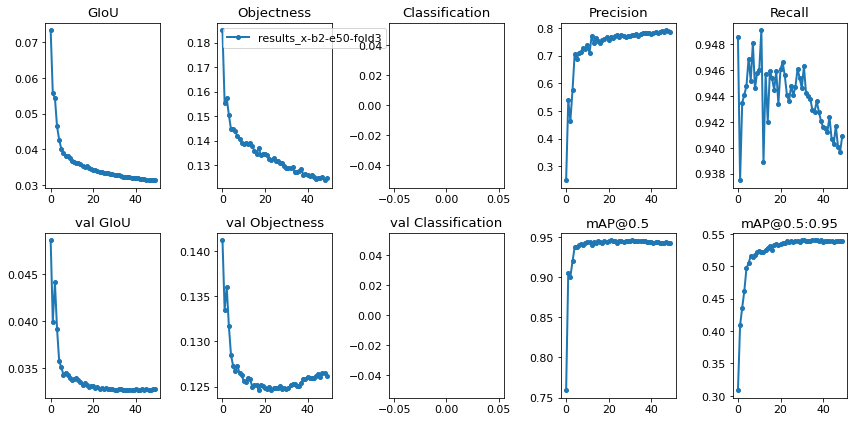

In [14]:
check_git_status()
class opt:
    epochs=50                #parser.add_argument('--epochs', type=int, default=300)
    batch_size=2            #parser.add_argument('--batch-size', type=int, default=16)
    cfg=cfg_input           #parser.add_argument('--cfg', type=str, default='models/yolov5s.yaml', help='*.cfg path')
    data=data_input         #parser.add_argument('--data', type=str, default='data/coco128.yaml', help='*.data path')
    img_size=[1024, 1024]   #parser.add_argument('--img-size', nargs='+', type=int, default=[640, 640], help='train,test sizes')
    rect=False              #parser.add_argument('--rect', action='store_true', help='rectangular training')
    resume=False            #parser.add_argument('--resume', action='store_true', help='resume training from last.pt')
    nosave=False            #parser.add_argument('--nosave', action='store_true', help='only save final checkpoint')
    notest=False            #parser.add_argument('--notest', action='store_true', help='only test final epoch')
    noautoanchor=False      #parser.add_argument('--noautoanchor', action='store_true', help='disable autoanchor check')
    evolve=False            #parser.add_argument('--evolve', action='store_true', help='evolve hyperparameters')
    bucket=''               #parser.add_argument('--bucket', type=str, default='', help='gsutil bucket')
    cache_images=False      #parser.add_argument('--cache-images', action='store_true', help='cache images for faster training')
    weights=weights_input   #parser.add_argument('--weights', type=str, default='', help='initial weights path')
    name=name_input         #parser.add_argument('--name', default='', help='renames results.txt to results_name.txt if supplied')
    device=''               #parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
    adam=False              #parser.add_argument('--adam', action='store_true', help='use adam optimizer')
    multi_scale=False       #parser.add_argument('--multi-scale', action='store_true', help='vary img-size +/- 50%')
    single_cls=False        #parser.add_argument('--single-cls', action='store_true', help='train as single-class dataset')

#parser = argparse.ArgumentParser()
#opt = parser.parse_args()

opt.weights = last if opt.resume and not opt.weights else opt.weights
opt.cfg = check_file(opt.cfg)  # check file
opt.data = check_file(opt.data)  # check file
print(opt)
opt.img_size.extend([opt.img_size[-1]] * (2 - len(opt.img_size)))  # extend to 2 sizes (train, test)
device = torch_utils.select_device(opt.device, apex=mixed_precision, batch_size=opt.batch_size)
if device.type == 'cpu':
    mixed_precision = False

# Train
if not opt.evolve:
    tb_writer = SummaryWriter(comment=opt.name)
    print('Start Tensorboard with "tensorboard --logdir=runs", view at http://localhost:6006/')
    train(hyp)

# Evolve hyperparameters (optional)
else:
    tb_writer = None
    opt.notest, opt.nosave = True, True  # only test/save final epoch
    if opt.bucket:
        os.system('gsutil cp gs://%s/evolve.txt .' % opt.bucket)  # download evolve.txt if exists

    for _ in range(10):  # generations to evolve
        if os.path.exists('evolve.txt'):  # if evolve.txt exists: select best hyps and mutate
            # Select parent(s)
            parent = 'single'  # parent selection method: 'single' or 'weighted'
            x = np.loadtxt('evolve.txt', ndmin=2)
            n = min(5, len(x))  # number of previous results to consider
            x = x[np.argsort(-fitness(x))][:n]  # top n mutations
            w = fitness(x) - fitness(x).min()  # weights
            if parent == 'single' or len(x) == 1:
                # x = x[random.randint(0, n - 1)]  # random selection
                x = x[random.choices(range(n), weights=w)[0]]  # weighted selection
            elif parent == 'weighted':
                x = (x * w.reshape(n, 1)).sum(0) / w.sum()  # weighted combination

            # Mutate
            mp, s = 0.9, 0.2  # mutation probability, sigma
            npr = np.random
            npr.seed(int(time.time()))
            g = np.array([1, 1, 1, 1, 1, 1, 1, 0, .1, 1, 0, 1, 1, 1, 1, 1, 1, 1])  # gains
            ng = len(g)
            v = np.ones(ng)
            while all(v == 1):  # mutate until a change occurs (prevent duplicates)
                v = (g * (npr.random(ng) < mp) * npr.randn(ng) * npr.random() * s + 1).clip(0.3, 3.0)
            for i, k in enumerate(hyp.keys()):  # plt.hist(v.ravel(), 300)
                hyp[k] = x[i + 7] * v[i]  # mutate

        # Clip to limits
        keys = ['lr0', 'iou_t', 'momentum', 'weight_decay', 'hsv_s', 'hsv_v', 'translate', 'scale', 'fl_gamma']
        limits = [(1e-5, 1e-2), (0.00, 0.70), (0.60, 0.98), (0, 0.001), (0, .9), (0, .9), (0, .9), (0, .9), (0, 3)]
        for k, v in zip(keys, limits):
            hyp[k] = np.clip(hyp[k], v[0], v[1])

        # Train mutation
        results = train(hyp.copy())

        # Write mutation results
        print_mutation(hyp, results, opt.bucket)

        # Plot results
        # plot_evolution_results(hyp)

In [15]:
import shutil
new_weight = '/content/drive/My Drive/Colab Notebooks/yolov5weights/' + name_input
if os.path.exists(new_weight):
  shutil.rmtree(new_weight)
os.mkdir(new_weight)

weight_last = '/content/yolov5/weights/last_' + name_input + '.pt'
weight_best = '/content/yolov5/weights/best_' + name_input + '.pt'

!cp '{weight_last}' '{new_weight}'
!cp '{weight_best}' '{new_weight}'
!cp 'results.png' '{new_weight}'
!cp 'labels.png' '{new_weight}'
!cp 'test_batch0_gt.jpg' '{new_weight}'
!cp 'test_batch0_pred.jpg' '{new_weight}'